In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import pandas as pd
import requests
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [80]:
# Fetching player and team data
fpl_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(fpl_url)
data = response.json()

players_df = pd.DataFrame(data['elements'])
teams_df = pd.DataFrame(data['teams'])

In [81]:
# Fetching fixture data
fixtures_response = requests.get('https://fantasy.premierleague.com/api/fixtures/')
fixtures_data = fixtures_response.json()

# Convert fixtures data to DataFrame
fixtures_df = pd.DataFrame(fixtures_data)
fixtures_df.columns


Index(['code', 'event', 'finished', 'finished_provisional', 'id',
       'kickoff_time', 'minutes', 'provisional_start_time', 'started',
       'team_a', 'team_a_score', 'team_h', 'team_h_score', 'stats',
       'team_h_difficulty', 'team_a_difficulty', 'pulse_id'],
      dtype='object')

In [82]:
player_team_fixture = pd.concat([players_df, teams_df,fixtures_df], axis=1)
#Removes duplicated comments
player_team_fixture = player_team_fixture.loc[:,~player_team_fixture.columns.duplicated()].copy()

In [84]:
team_id_to_name = teams_df.set_index('id')['name'].to_dict()
player_team_fixture['Home_team_name'] = player_team_fixture['team_h'].map(team_id_to_name)
player_team_fixture['Away_team_name'] = player_team_fixture['team_a'].map(team_id_to_name)

In [85]:
#Dropped columns with na's above a certain threshold
threshold = int(0.5 * 100)
df_elements = player_team_fixture.dropna(thresh = threshold, axis = 1)

In [86]:
#Dropping unecessary columns
player_team_fixture = player_team_fixture.drop(['first_name', 'second_name', 'photo', 'news', 'web_name', 'stats','points_per_game'], axis = 1)

In [87]:
#Gets the numeric data and imputes the empty rows
numeric_data = player_team_fixture.select_dtypes(include=['int64', 'float64'])
numeric_data_imputer = SimpleImputer(strategy='mean')
numeric_data_filled = numeric_data_imputer.fit_transform(numeric_data)
numeric_data_df = pd.DataFrame(numeric_data_filled, columns=numeric_data.columns)

In [88]:
#Gets the categorical data, imputes the data and encodes the data
categorical_data = player_team_fixture.select_dtypes(include=['object'])
categorical_data_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_filled = categorical_data_imputer.fit_transform(categorical_data)
encoder = OrdinalEncoder()
categorical_data_encoded = encoder.fit_transform(categorical_data_filled)
categorical_data_df = pd.DataFrame(categorical_data_encoded, columns=categorical_data.columns)

In [89]:
player_team_fixture = pd.concat([numeric_data_df, categorical_data_df], axis=1)

In [90]:
corr_matrix = player_team_fixture.corr()

In [91]:
correlations = corr_matrix['total_points'].loc[corr_matrix['total_points'].abs() > 0.5].sort_values(ascending=False)
correlations

total_points                  1.000000
bps                           0.942250
minutes                       0.903948
starts                        0.900814
bonus                         0.889762
clean_sheets                  0.866748
expected_assists              0.803684
goals_conceded                0.789913
goals_scored                  0.771917
assists                       0.760461
expected_goals                0.730301
starts_per_90                 0.680605
now_cost                      0.678274
expected_goal_involvements    0.672585
expected_goals_conceded       0.651343
clean_sheets_per_90           0.632075
influence                     0.622774
yellow_cards                  0.622422
ep_next                       0.585956
selected_by_percent           0.552435
creativity                    0.535390
form_rank                     0.527811
form_rank_type                0.500675
now_cost_rank_type           -0.522533
selected_rank                -0.568614
now_cost_rank            

In [92]:
features = player_team_fixture[['bps','minutes', 'assists', 'goals_conceded', 'goals_scored']]

In [93]:
x = features
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = player_team_fixture['total_points']

In [94]:
#random_state = Means we want to randomize the data
Xtrain,Xtest,Ytrain,Ytest = train_test_split(x,y,test_size=0.2, random_state=42)

In [95]:
rf_model = RandomForestRegressor()
rf_model.fit(Xtrain,Ytrain)
y_pred = rf_model.predict(Xtest)
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred,Ytest)},
Mean Squared Error = {mean_squared_error(y_pred,Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred,Ytest))},
R2 Score = {r2_score(y_pred, Ytest)}
          """)


Mean Absolute Error = 4.717036723163843,
Mean Squared Error = 57.81090836487759,
Root Mean Squared Error = 7.603348496871466,
R2 Score = 0.9766947020176094
          


In [96]:
# xgb regressor to train model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(Xtrain, Ytrain)
y_pred = xgb_model.predict(Xtest)
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred,Ytest)},
Mean Squared Error = {mean_squared_error(y_pred,Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred,Ytest))},
R2 Score = {r2_score(y_pred, Ytest)}
          """)


Mean Absolute Error = 4.54781523763431,
Mean Squared Error = 57.72959056678427,
Root Mean Squared Error = 7.597999116003125,
R2 Score = 0.9777500658956382
          


In [97]:
gdr_model = GradientBoostingRegressor()
gdr_model.fit(Xtrain,Ytrain)
y_pred = gdr_model.predict(Xtest)
print(f"""
Mean Absolute Error = {mean_absolute_error(y_pred,Ytest)},
Mean Squared Error = {mean_squared_error(y_pred,Ytest)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(y_pred,Ytest))},
R2 Score = {r2_score(y_pred, Ytest)}
          """)


Mean Absolute Error = 4.765151836772058,
Mean Squared Error = 52.87263563328587,
Root Mean Squared Error = 7.2713572071028025,
R2 Score = 0.9794666381634693
          


In [98]:
# Define the model
model = Sequential([
    Dense(64, input_dim=Xtrain.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(Xtrain, Ytrain, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(Xtest, Ytest)
print(f'Test Loss: {loss:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5018.5142 - val_loss: 3685.9341
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4744.0171 - val_loss: 3609.4456
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4886.5176 - val_loss: 3509.3857
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4652.3418 - val_loss: 3368.9961
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4627.2051 - val_loss: 3173.4229
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4219.7451 - val_loss: 2914.6543
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3781.7610 - val_loss: 2586.7617
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3276.8689 - val_loss: 2194.4299
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2558.3479 - val_loss: 1746.7356
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2005.5143 - val_loss: 1279.0588
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1341.4937 - val_loss: 871.1179
Ep

In [99]:
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}
grid_search = GridSearchCV(estimator = xgb_model, param_grid = parameters, cv=5, scoring='neg_mean_squared_error')

In [100]:
#Fit the grid search on the training data
grid_search.fit(Xtrain, Ytrain)
#Gets the best parameters
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
best_rmse_xgb = np.sqrt(best_score)
print("Best Parameters:", best_params)
print("Best CV RMSE: %.4f" % best_score)
print("Best CV RMSE (XGB): %.4f" % best_rmse_xgb)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Best CV RMSE: 70.6879
Best CV RMSE (XGB): 8.4076


In [101]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [102]:
#Gets the best parameters
best_params = rf_grid_search.best_params_
best_score = -rf_grid_search.best_score_
best_rmse_rf = np.sqrt(best_score)
print("Best Parameters:", best_params)
print("Best CV RMSE: %.4f" % best_score)
print("Best CV RMSE (Random Forest): %.4f" % best_rmse_rf)

Best Parameters: {'max_depth': 30, 'n_estimators': 100}
Best CV RMSE: 73.9314
Best CV RMSE (Random Forest): 8.5983


In [103]:
gdr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}
gdr_grid_search = GridSearchCV(estimator=gdr_model, param_grid=gdr_param_grid, cv=5, scoring='neg_mean_squared_error')
gdr_grid_search.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [104]:
best_params = gdr_grid_search.best_params_
best_score = -gdr_grid_search.best_score_
best_rmse_gdr = np.sqrt(best_score)
print("Best Parameters:", best_params)
print("Best CV RMSE: %.4f" % best_score)
print("Gradient Boosting Best CV RMSE: %.4f" % best_rmse_gdr)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV RMSE: 69.6317
Gradient Boosting Best CV RMSE: 8.3446


In [ ]:
#After looking at the Mean Squared Error and RMSE from grid search, gradient boosting appeared to be the best model
#It had the lowest Mean Squared Error and the lowest RMSE amongst the grid search

##Testing the trained model with input features from another dataset

In [105]:
test_data = pd.read_csv('/content/drive/MyDrive/merged_gwtest.csv')

In [106]:
numeric_data_test = test_data.select_dtypes(include=['int64', 'float64'])
numeric_data_test_imputer = SimpleImputer(strategy='mean')
numeric_data_test_filled = numeric_data_test_imputer.fit_transform(numeric_data_test)
numeric_data_test_df = pd.DataFrame(numeric_data_test_filled, columns=numeric_data_test.columns)

In [107]:
categorical_data_test = test_data.select_dtypes(include=['object'])
categorical_data_test_imputer = SimpleImputer(strategy='most_frequent')
categorical_data_test_filled = categorical_data_test_imputer.fit_transform(categorical_data_test)
encoder = OrdinalEncoder()
categorical_data_test_encoded = encoder.fit_transform(categorical_data_test_filled)
categorical_data_test_df = pd.DataFrame(categorical_data_test_encoded, columns=categorical_data_test.columns)

In [108]:
test_data = pd.concat([numeric_data_test_df, categorical_data_test_df], axis=1)

In [109]:
test_features = test_data[['bps','minutes', 'assists', 'goals_conceded', 'goals_scored']]
test_x = test_features
test_x = scaler.transform(test_x)
test_y = test_data['total_points']

In [110]:
Xtrain1,Xtest1,Ytrain1,Ytest1 = train_test_split(test_x,test_y,test_size=0.2, random_state=42)

In [116]:
gdr_model.fit(Xtrain1, Ytrain1)
test_ypred = gdr_model.predict(Xtest1)
print(f"""
Mean Absolute Error = {mean_absolute_error(test_ypred,Ytest1)},
Mean Squared Error = {mean_squared_error(test_ypred,Ytest1)},
Root Mean Squared Error = {np.sqrt(mean_squared_error(test_ypred,Ytest1))},
R2 Score = {r2_score(test_ypred,Ytest1)}
          """)



Mean Absolute Error = 0.21484348328564296,
Mean Squared Error = 0.250591047616373,
Root Mean Squared Error = 0.5005906986914289,
R2 Score = 0.9496550497948436
          


In [112]:
#A score of 0.9497 means that the random forest model fits the test data very well

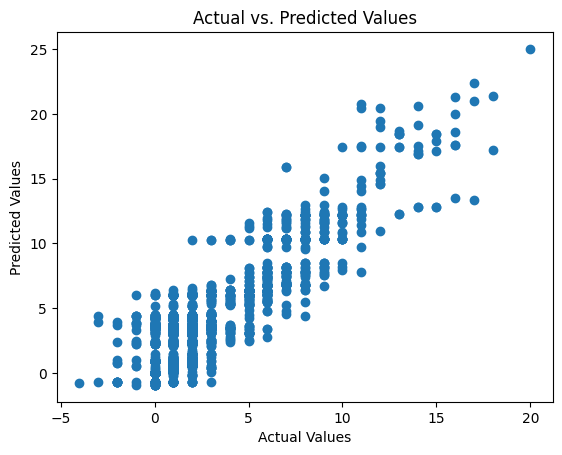

In [113]:
plt.scatter(Ytest1, test_ypred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [114]:
# Save the model
with open('rf_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [117]:
# Save the model
with open('gdr_model.pkl', 'wb') as model_file:
    pickle.dump(gdr_model, model_file)